In [1]:
from modelxs_infer import uniformer_xxs

/home/tancuong/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from decord import VideoReader

import json

In [3]:
# state_dict = torch.load('test_models/uniformer_xs32_192_k400.pth', map_location='cpu')
# xs_model = uniformer_xs()
# xs_model.load_state_dict(state_dict)
# xs_model.eval()

In [3]:
data_path = ""
train_set = data_path+"Train"
test_set = data_path+"Test"

id2label = {"0": "an", "1": "ban", "2": "ban dem",
              "3": "ban ngay", "4": "bo", "5": "cam on",
              "6": "choi", "7": "cuoi", "8": "di", "9": "di hoc",
              "10": "khoc", "11": "lam viec", "12": "me",
              "13": "moi ngay", "14": "sach", "15": "toi",
              "16": "viet", "17": "xem", "18": "xin chao", "19": "xin loi"}
id2label = {int(id):id2label[id] for id in list(dict.keys(id2label))}
label2id = {id2label[id]:id for id in list(dict.keys(id2label))}
print(label2id)
with open('label_list.json','w') as outfile:
    json.dump(id2label,outfile)

{'an': 0, 'ban': 1, 'ban dem': 2, 'ban ngay': 3, 'bo': 4, 'cam on': 5, 'choi': 6, 'cuoi': 7, 'di': 8, 'di hoc': 9, 'khoc': 10, 'lam viec': 11, 'me': 12, 'moi ngay': 13, 'sach': 14, 'toi': 15, 'viet': 16, 'xem': 17, 'xin chao': 18, 'xin loi': 19}


In [4]:
input_size = 160
num_frame = 16 # resampling test
# sampling_rate = 2
batch_size = 32
input_mean = [0.485, 0.456, 0.406]
input_std = [0.229, 0.224, 0.225]
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=1)

In [5]:
def read_video(file_path):
    vr = VideoReader(file_path)
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(
        frames,
        output_size=(input_size, input_size)
    )

def format_frames(frame, output_size):
    frame = torch.tensor(frame*255,dtype=torch.float32)
    crop_size = min(frame.shape[1:3])
    frame = frame.permute(0, 3, 1, 2)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop((crop_size,crop_size)),
        # transforms.ColorJitter(brightness=(0.6,0.9),
        #                           contrast=(0.6,0.9),
        #                           hue=(-0.5,0.5),
        #                           saturation=(0.7,0.9)),
        # transforms.RandomRotation(3,expand=True),
        transforms.Resize(output_size),
        transforms.ToTensor(),
        # transforms.Normalize(input_mean, input_std)
    ])
    frame = [transform(f) for f in frame]
    video = torch.stack(frame)
    return video

def resample_video(video_tensor, target_frames=16):
    num_frames, channels, height, width = video_tensor.size()
    indices = torch.linspace(0, num_frames - 1, steps=target_frames).round().long()
    resampled_video = []
    for idx in indices:
        resampled_video.append(video_tensor[idx])
    return torch.stack(resampled_video)

def load_video(file_path, label, resampling=True):
    video = read_video(file_path) 
    if resampling: 
        video = resample_video(video, target_frames=num_frame)
    video = video.permute(1, 0, 2, 3)
    label = torch.tensor(label, dtype=torch.long)
    return video, label

In [6]:
video, label = load_video(train_set+"/ban ngay/0.mp4",3)
print(video.shape,label)

torch.Size([3, 16, 160, 160]) tensor(3)


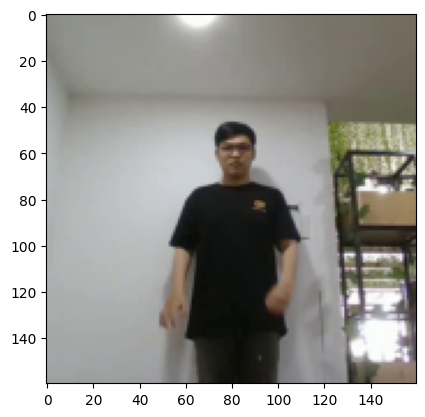

In [7]:
import matplotlib.pyplot as plt
demo = video.permute(1,2,3,0)[0]
plt.imshow(demo)

In [7]:
def create_dataframe(path):
    data = []

    for class_name in os.listdir(path):
        class_dir = os.path.join(path, class_name)
        if os.path.isdir(class_dir) and class_name in label2id:
            for video_file in os.listdir(class_dir):
                video_path = os.path.join(class_dir, video_file)
                data.append({
                    'video_path': os.path.abspath(video_path),
                    'label': label2id[class_name],
                    'class_name': class_name
                })

    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_df = create_dataframe(train_set)
test_df = create_dataframe(test_set)
train_df.shape, test_df.shape

((3240, 3), (360, 3))

In [8]:
def create_dataloader(ds, batch_size, shuffle=True):
    while True:
        if shuffle:
            ds = ds.sample(frac=1).reset_index(drop=True)
        for i in range(batch_size-1, len(ds), batch_size):
            X_batch, y_batch = [], []
            for j in range(i,i-batch_size,-1):
                video, label = load_video(ds.iloc[j][0], ds.iloc[j][1])
                X_batch.append(video)
                y_batch.append(label) 
            yield torch.stack(X_batch), torch.stack(y_batch)
            X_batch, y_batch = [], []

In [11]:
# x, y = next(iter(train_loader))
# x.shape, y

In [9]:
state_dict = torch.load('uniformer_xxs32_160_k400.pth', map_location='cpu')
xxs_model = uniformer_xxs()
xxs_model.load_state_dict(state_dict)
for param in xxs_model.parameters():
    param.requires_grad = False

In [11]:
class UniformerXXSFinetune(torch.nn.Module):
    def __init__(self, out_class=20):
        super(UniformerXXSFinetune, self).__init__()
        self.pretrained = xxs_model
        self.fc = torch.nn.Linear(400,out_class)

    def forward(self, x):
        x = self.pretrained(x)[0]
        x = self.fc(x)
        return F.softmax(x,dim=-1)

# Instantiate the model
model = UniformerXXSFinetune().to(device)
from torchinfo import summary
input_random = torch.randn(8,3,16,160,160).to(device)
# output = model(input_random)
summary(model,input_data=input_random)

Layer (type:depth-idx)                   Output Shape              Param #
UniformerXXSFinetune                     [8, 20]                   --
├─Uniformer_light: 1-1                   [8, 400]                  1,120
│    └─SpeicalPatchEmbed: 2-1            [8, 56, 8, 40, 40]        --
│    │    └─Sequential: 3-1              [8, 56, 8, 40, 40]        (44,856)
│    └─Dropout: 2-2                      [8, 56, 8, 40, 40]        --
│    └─ModuleList: 2-3                   --                        --
│    │    └─CBlock: 3-2                  [8, 56, 8, 40, 40]        (34,272)
│    │    └─CBlock: 3-3                  [8, 56, 8, 40, 40]        (34,272)
│    └─PatchEmbed: 2-4                   [8, 112, 8, 20, 20]       --
│    │    └─Conv3d: 3-4                  [8, 112, 8, 20, 20]       (25,200)
│    │    └─LayerNorm: 3-5               [8, 3200, 112]            (224)
│    └─ModuleList: 2-5                   --                        --
│    │    └─CBlock: 3-6                  [8, 112, 8, 20

In [20]:
model.eval()
test_input = torch.randn(3,16,160,160).to(device)
test_input = test_input.expand(1,3,16,160,160)
print(test_input.shape)
test_output = model(test_input)
print(test_output.shape)

torch.Size([1, 3, 16, 160, 160])
torch.Size([1, 20])


In [14]:
train_loader = create_dataloader(train_df, batch_size=batch_size)
test_loader = create_dataloader(test_df, batch_size=batch_size)
epochs = 10
lr = 1e-3
decay_step = 5
decay = 0.9
train_steps_per_epoch = len(train_df)//batch_size
test_steps_per_epoch = len(test_df)//batch_size

In [16]:
# train loop definition
from torchmetrics import Accuracy
from torch import optim
from tqdm import tqdm

acc = Accuracy(task='multiclass',num_classes=20).to(device)
criterion = torch.nn.CrossEntropyLoss()

def train_epoch(epoch):
    learning_rate = lr*decay**(epoch/decay_step)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    train_loss = 0.
    acc.reset()
    model.train()

    for _ in tqdm(range(train_steps_per_epoch)):
        optimizer.zero_grad()
        inputs, labels = next(iter(train_loader))
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        acc.update(outputs,labels)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()

    accuracy = acc.compute().item()
    print(f'Epoch {epoch} - Learning rate {learning_rate} - Train loss: {round(train_loss/train_steps_per_epoch,4)} - Train acc: {round(accuracy,4)}')
    
    return (train_loss, accuracy, learning_rate)

def val_epoch(epoch, best_val_loss):
    model.eval()
    val_loss = 0.
    acc.reset()

    with torch.no_grad():
        for _ in tqdm(range(test_steps_per_epoch)):
            inputs, labels = next(iter(test_loader))
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            acc.update(outputs,labels)
            val_loss+=loss.item()

    accuracy = acc.compute().item()
    overall_loss = val_loss/test_steps_per_epoch

    if overall_loss<best_val_loss:
        # checkpoint
        torch.save(model.state_dict(), "xxs_finetuning_5_checkpoint_epoch_{}.pth".format(epoch))
        best_val_loss = overall_loss

    print(f'Val loss: {round(overall_loss,4)} - Val acc: {round(accuracy,4)}')
    return (val_loss, accuracy)

In [17]:
# start_train
model.to(device)
best_val_loss = 1000.
import json
# with open('history.json',"r") as infile:
#     history = json.load(infile)
history = []
for i in range(1,epochs+1):
    train_loss, train_acc, lr = train_epoch(i)
    val_loss, val_acc = val_epoch(i, best_val_loss)
    history.append({
        'epoch':i,
        't_acc':train_acc,
        't_loss':train_loss,
        'v_acc':val_acc,
        'v_loss':val_loss,
        'lr':lr
    })
with open('history.json',"w") as outfile:
    json.dump(history,outfile)

  0%|          | 0/101 [00:00<?, ?it/s]/tmp/ipykernel_1293066/477344941.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  video, label = load_video(ds.iloc[j][0], ds.iloc[j][1])
 99%|█████████▉| 100/101 [09:49<00:05,  5.62s/it]

In [ ]:
torch.save(model.state_dict(),'uniformer_xxs_finetune_2.pth')

In [ ]:
with open('history.json','r') as infile:
    data = json.load(infile)
for record in data:
    record['t_loss']/=train_steps_per_epoch*batch_size
    record['v_loss']/=test_steps_per_epoch*batch_size
with open('history.json',"w") as outfile:
    json.dump(data,outfile)

In [12]:
model.load_state_dict(torch.load('xxs_finetuning_5_checkpoint_epoch_5.pth'))

<All keys matched successfully>

In [15]:
from torchmetrics import Accuracy
from tqdm import tqdm
from time import time
model.eval()

acc = Accuracy(task='multiclass',num_classes=20).to(device)
start = time()
with torch.no_grad():
    for _ in tqdm(range(test_steps_per_epoch)):
        inputs, labels = next(iter(test_loader))
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        acc.update(outputs,labels)

accuracy = acc.compute().item()
end = time()
# if overall_loss<best_val_loss:
#     # checkpoint
#     torch.save(model.state_dict(), "xxs_finetuning_5_checkpoint_epoch_{}.pth".format(epoch))
#     best_val_loss = overall_loss

print(f'Accuracy: {round(accuracy,4)}, total test time: {(end-start)}')


  0%|          | 0/11 [00:00<?, ?it/s]

/tmp/ipykernel_1718186/477344941.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  video, label = load_video(ds.iloc[j][0], ds.iloc[j][1])
100%|██████████| 11/11 [00:57<00:00,  5.24s/it]

Accuracy: 0.9403, total test time: 57.73634719848633


In [26]:
video, label = load_video(train_set+"/ban ngay/0.mp4",3)
from time import time
video = video.expand(1,3,16,160,160)
video = video.to(device)
model.to(device)
model.eval()
start = time()
output = model(video)
end = time()
output = output.cpu().detach().numpy()
# output = output.detach().numpy()
output = output.argmax()
print(f'True label: {label}, predicted label: {output}')
print(f'Inference time: {end-start}')

True label: 3, predicted label: 3
Inference time: 0.019353389739990234
